<a href="https://colab.research.google.com/github/Romulol-B/Image_Matching_2025/blob/main/loftr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
import torch
import cv2
import numpy as np
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
import shutil
from PIL import Image
import torchvision
import random
from torchvision import transforms


In [4]:
!kaggle competitions download -c image-matching-challenge-2025
!unzip -q image-matching-challenge-2025

100% 4.83G/4.84G [01:08<00:00, 110MB/s] 
100% 4.84G/4.84G [01:09<00:00, 75.0MB/s]


In [11]:
brightness=(0.98, 1.02)
gamma=(0.5, 1.1)
gaussian_std=(0,0.02)
resolution = (256 , 256)

In [5]:
def data_augmentation(img, brightness=(0.98, 1.02), gamma=(0.5, 1.1), gaussian_std=(0,0.02)):
  img = (img + 1) / 2  # Map from [-1, 1] to [0, 1] if normalized

  gamma_val = random.uniform(gamma[0], gamma[1])
  img = transforms.functional.adjust_gamma(img, gamma_val)

  brightness_val = random.uniform(brightness[0], brightness[1])
  img = transforms.functional.adjust_brightness(img, brightness_val)
  # Gaussian noise (if needed)
  noise = torch.randn_like(img) * random.uniform(gaussian_std[0],gaussian_std[1])
  img = img + noise

  # Clamp and re-normalize to [-1, 1]
  img = torch.clamp(img, 0, 1)  # First clamp to [0, 1]
  img = img * 2 - 1  # Map back to [-1, 1]

  return img

In [36]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # [0, 1]
    transforms.Normalize(mean=[0.5], std=[0.5]),  # [-1, 1]
    transforms.Grayscale(),
    transforms.RandomApply(
        [transforms.Lambda(lambda x: data_augmentation(x))],
        p=0.5  # 50% chance to apply
    ),
])
kaggle_data = torchvision.datasets.ImageFolder('/content/train/',transform=transform)
data_loader = torch.utils.data.DataLoader(kaggle_data, batch_size=1)

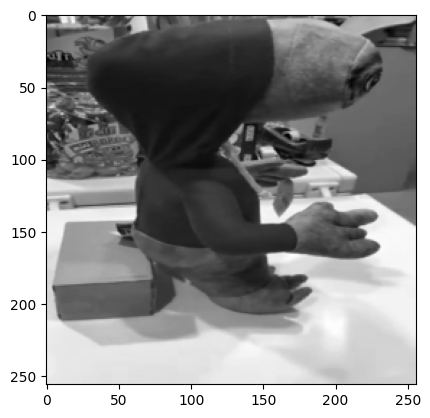

In [37]:
img, label = kaggle_data[9]
plt.imshow(img.permute(1, 2, 0),cmap='grey')

loftr

In [38]:
# Configure environment and grab LoFTR code.
!rm -rf sample_data
!pip install torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
!mv LoFTR/* . && rm -rf LoFTR

# Download pretrained weights
!mkdir weights
%cd weights/
!gdown --id 1w1Qhea3WLRMS81Vod_k5rxS_GNRgIi-O  # indoor-ds
!gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds
%cd ..

Cloning into 'LoFTR'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 173 (delta 27), reused 136 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (173/173), 26.27 MiB | 26.30 MiB/s, done.
Resolving deltas: 100% (27/27), done.
mv: cannot move 'LoFTR/assets' to './assets': Directory not empty
mv: cannot move 'LoFTR/configs' to './configs': Directory not empty
mv: cannot move 'LoFTR/data' to './data': Directory not empty
mv: cannot move 'LoFTR/demo' to './demo': Directory not empty
mv: cannot move 'LoFTR/docs' to './docs': Directory not empty
mv: cannot move 'LoFTR/notebooks' to './notebooks': Directory not empty
mv: cannot move 'LoFTR/scripts' to './scripts': Directory not empty
mv: cannot move 'LoFTR/src' to './src': Directory not empty
mv: cannot move 'LoFTR/third_party' to './third_party': Directory not empty
mkdir: cannot create directory ‘weights’: File exists
/conten

In [39]:
import torch
import cv2
import numpy as np
import matplotlib.cm as cm

from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg

In [40]:
# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
matcher = LoFTR(config=default_cfg)
image_type='outdoor'
if image_type == 'indoor':
  matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'])
elif image_type == 'outdoor':
  matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
else:
  raise ValueError("Wrong image_type is given.")
matcher = matcher.eval().cpu()

In [54]:
img, label = kaggle_data[0]
img = (img.flatten(start_dim=0,end_dim=1))
img.shape

torch.Size([256, 256])

In [59]:
img = img[None,None,:,:]
assert img.shape ==(1,1,resolution[0],resolution[1])

img.shape

torch.Size([1, 1, 256, 256])

In [78]:
def group_matching(vetor_imgs = kaggle_data,n=9):
  for i in range(n):
    img0_raw ,_ = vetor_imgs[0]
    img01_raw ,_ = vetor_imgs[i +1]
    img0_raw = img0_raw.flatten(start_dim=0,end_dim=1)
    img01_raw = img01_raw.flatten(start_dim=0,end_dim=1)


    img0 = img0_raw[None,None,:,:]
    assert img0.shape ==(1,1,resolution[0],resolution[1])
    print(img0.shape)
    img01 = img01_raw[None,None,:,:]
    assert img01.shape ==(1,1,resolution[0],resolution[1])

    batch = {'image0': img0, 'image1': img01}

    # Inference with LoFTR and get prediction
    with torch.no_grad():
        matcher(batch)
        mkpts0 = batch['mkpts0_f'].cpu().numpy()
        mkpts1 = batch['mkpts1_f'].cpu().numpy()
        mconf = batch['mconf'].cpu().numpy()
  # Draw
    color = cm.jet(mconf, alpha=0.7)
    text = [
        'LoFTR',
        'Matches: {}'.format(len(mkpts0)),
    ]
    fig = make_matching_figure(img0_raw, img01_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text)

    # A high-res PDF will also be downloaded automatically.
    make_matching_figure(img0_raw, img01_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text, path="LoFTR-colab-demo.pdf")


torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


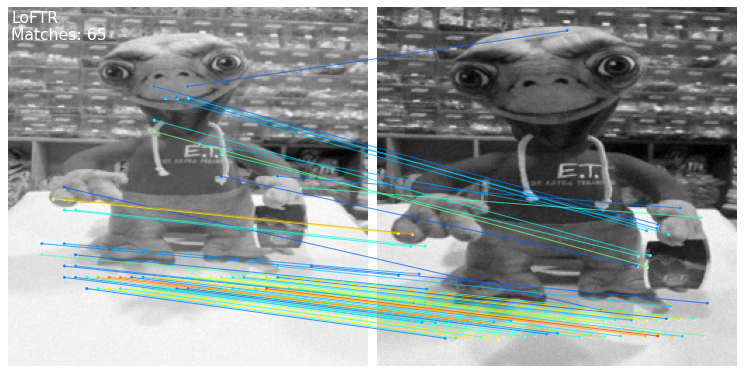

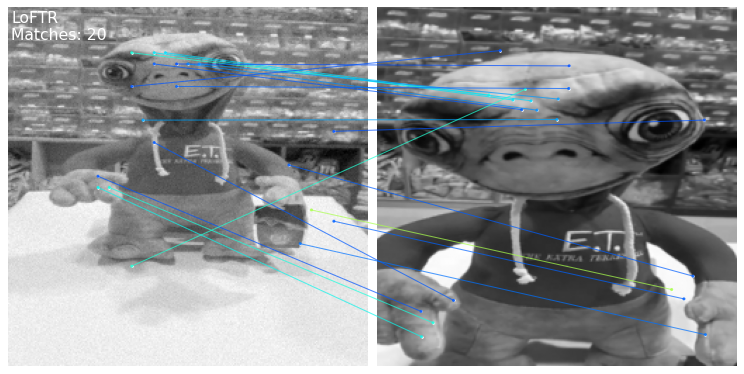

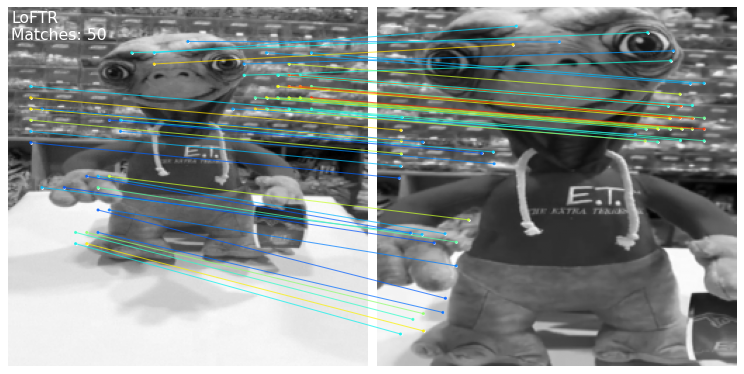

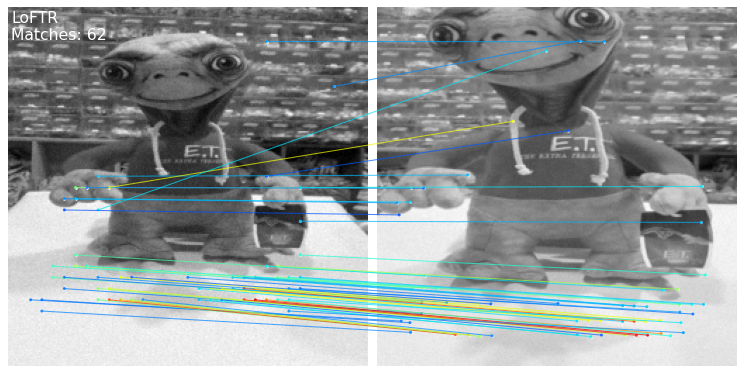

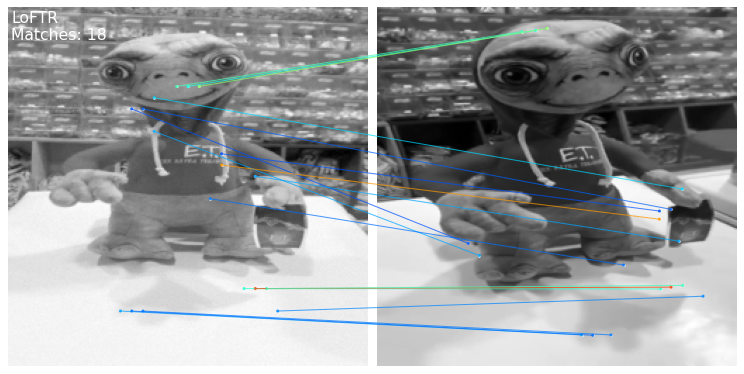

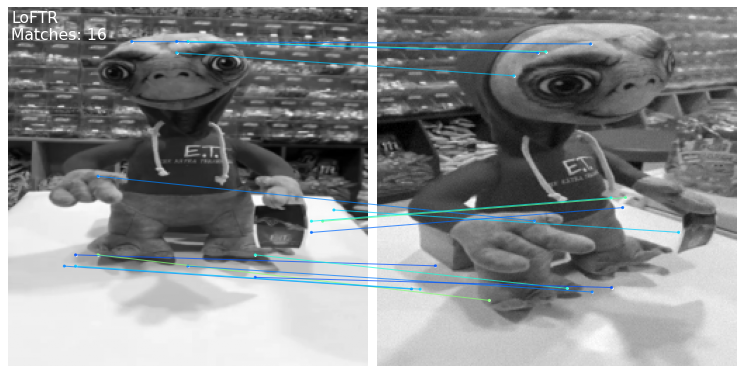

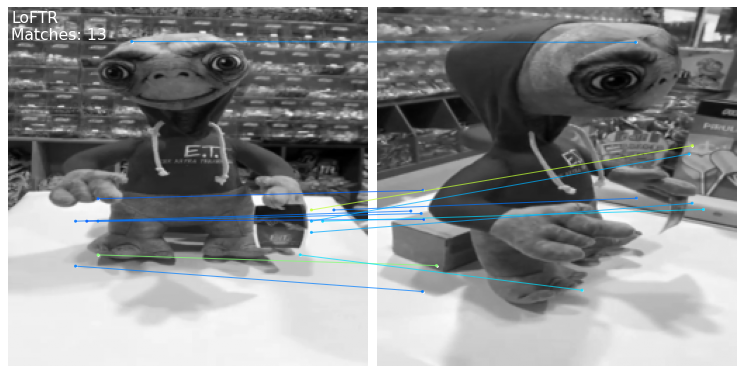

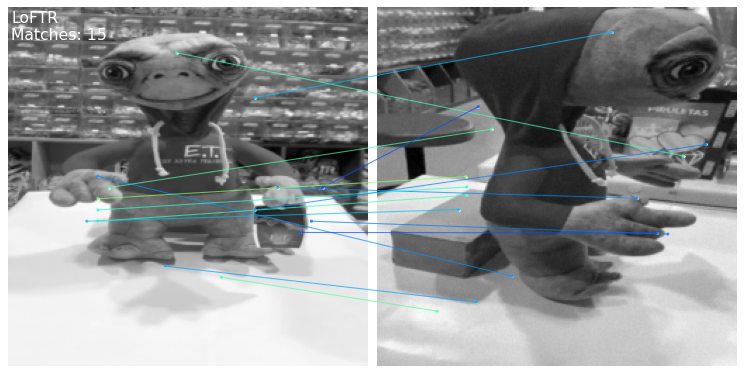

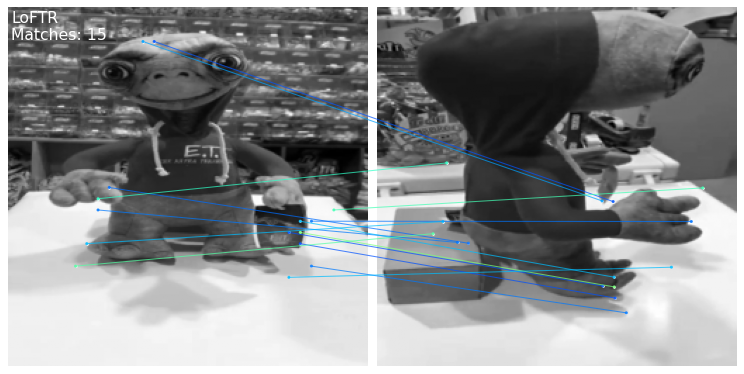

In [79]:
group_matching()